In [1]:
from benchmark import *
from utils import *

import cellxgene_census
from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
import somacore as soma
from somacore import AxisQuery
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

### [Papermill](https://papermill.readthedocs.io/en/latest/) params:

In [2]:
# Set to None to fetch from S3
census_uri = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'

# Slice 138 total datasets
start = 2
end = 7

n_epochs = 1
BATCH_SIZE = 1024
n_vars = 20_000
SOMA_CHUNK_SIZE = 10_000
gc_freq: Optional[int] = None  # When set, run `gc.collect()` every `gc_freq` batches

# Plot configs
period = 10  # Color batch timings by this modulus (to highlight periodic artifacts)
ann_cutoff = .5  # Annotate plot with values for batch timings greater than this threshold
log_plot = False
width = 1200
height = 700

In [3]:
if not census_uri:
    census_uri = None
if census_uri and census_uri.startswith('/'):
    census_loc = 'local'
else:
    census_loc = 'S3'
err(f"Using {census_loc} census")

Using local census


In [4]:
tdbs = TileDBSomaStats()
tdb = TileDBStats()

In [5]:
with tdbs.collect('open_soma'), tdb.collect('open_soma'):
    census = cellxgene_census.open_soma(uri=census_uri)


#reference = ln.Collection.filter(uid="1gsdckxvOvIjQgeDVS1F").one().reference
reference = '283d65eb-dd53-496d-adb7-7570c7caa443'
query_collection_id = f"collection_id == '{reference}'"

with tdbs.collect('datasets'), tdb.collect('datasets'):
    datasets = (
        census["census_info"]["datasets"]
        .read(
            column_names=["dataset_id"],
            value_filter=query_collection_id,
        )
        .concat()
        .to_pandas()
        ["dataset_id"]
        .tolist()
    )

datasets[:10]

['8e10f1c4-8e98-41e5-b65f-8cd89a887122',
 'b165f033-9dec-468a-9248-802fc6902a74',
 'ff7d15fa-f4b6-4a0e-992e-fd0c9d088ded',
 'fe1a73ab-a203-45fd-84e9-0f7fd19efcbd',
 'fbf173f9-f809-4d84-9b65-ae205d35b523',
 'fa554686-fc07-44dd-b2de-b726d82d26ec',
 'f9034091-2e8f-4ac6-9874-e7b7eb566824',
 'f8dda921-5fb4-4c94-a654-c6fc346bfd6d',
 'f7d003d4-40d5-4de8-858c-a9a8b48fcc67',
 'f6d9f2ad-5ec7-4d53-b7f0-ceb0e7bcd181']

In [6]:
len(datasets)

138

In [7]:
experiment = census["census_data"]["homo_sapiens"]
experiment

<Experiment 'file:///mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'ms': 'file:///mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/ms' (unopened)
    'obs': 'file:///mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma/census_data/homo_sapiens/obs' (unopened)>

In [8]:
def get_exp_datapipe(start=None, end=None) -> Exp:
    ds = datasets[slice(start, end)]
    query_datasets = "dataset_id in " + str(ds)
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=AxisQuery(value_filter=query_datasets),
        var_query=AxisQuery(coords=(slice(n_vars-1),)),
        batch_size=BATCH_SIZE,
        shuffle=True,
        soma_chunk_size=SOMA_CHUNK_SIZE,
    )
    loader = experiment_dataloader(experiment_datapipe)
    return Exp(experiment_datapipe, loader)

In [9]:
%%time
exp = get_exp_datapipe(start=start, end=end)
exp.datapipe.shape[0]

CPU times: user 8.06 s, sys: 2.13 s, total: 10.2 s
Wall time: 608 ms


133790

## Run benchmark

In [10]:
%%time
epochs = []
for epoch in range(n_epochs):
    with tdbs.collect(f'benchmark-epoch{epoch}'), tdb.collect(f'benchmark-epoch{epoch}'):
        epoch = benchmark(exp, batch_size=BATCH_SIZE, gc_freq=gc_freq)
    epochs.append(epoch)

results = Results(
    census=Method('census', epochs),
)

100%|██████████████████| 130/130 [01:14<00:00,  1.74it/s]


time per sample: 560.31 μs
samples per sec: 1784.74 samples/sec
CPU times: user 1min 36s, sys: 52 s, total: 2min 28s
Wall time: 1min 20s


In [11]:
tdbs.stats

{'open_soma': [],
 'datasets': [{'timers': {'Context.StorageManager.sm_load_fragment_metadata.sum': 0.00012045,
    'Context.StorageManager.sm_load_fragment_metadata.avg': 6.0225e-05,
    'Context.StorageManager.sm_load_filtered_fragment_uris.sum': 4.4401e-05,
    'Context.StorageManager.sm_load_filtered_fragment_uris.avg': 2.22005e-05,
    'Context.StorageManager.sm_load_array_schemas_and_fragment_metadata.sum': 0.00040698,
    'Context.StorageManager.sm_load_array_schemas_and_fragment_metadata.avg': 0.00020349,
    'Context.StorageManager.sm_load_array_schema_from_uri.sum': 0.000207001,
    'Context.StorageManager.sm_load_array_schema_from_uri.avg': 0.000103501,
    'Context.StorageManager.sm_load_array_metadata.sum': 8.6855e-05,
    'Context.StorageManager.sm_load_array_metadata.avg': 8.6855e-05,
    'Context.StorageManager.sm_load_all_array_schemas.sum': 0.000224512,
    'Context.StorageManager.sm_load_all_array_schemas.avg': 0.000112256,
    'Context.StorageManager.array_open_read

In [12]:
tdb.stats

{'open_soma': [{'timers': {'Context.StorageManager.sm_load_group_metadata.sum': 0.000127858,
    'Context.StorageManager.sm_load_group_metadata.avg': 0.000127858,
    'Context.StorageManager.sm_load_group_from_uri.sum': 0.000109414,
    'Context.StorageManager.sm_load_group_from_uri.avg': 0.000109414,
    'Context.StorageManager.sm_load_group_details.sum': 0.000114139,
    'Context.StorageManager.sm_load_group_details.avg': 0.000114139,
    'Context.StorageManager.group_open_for_reads.sum': 0.000116627,
    'Context.StorageManager.group_open_for_reads.avg': 0.000116627},
   'counters': {'Context.StorageManager.read_unfiltered_byte_num': 373,
    'Context.StorageManager.read_group_size': 104,
    'Context.StorageManager.read_array_meta_size': 269,
    'Context.StorageManager.VFS.read_ops_num': 9,
    'Context.StorageManager.VFS.read_byte_num': 504,
    'Context.StorageManager.VFS.ls_num': 3,
    'Context.StorageManager.VFS.is_object_num': 1}}],
 'datasets': [{'timers': {'Context.Storage

In [13]:
results_json_path = f'results-{census_loc}.json'
with open(results_json_path, 'w') as f:
    json.dump(asdict(results), f, indent=2)
    err(f"Saved results to {results_json_path}")

Saved results to results-local.json


In [14]:
# with open(results_json_path, 'r') as f:
#     results = Results(**json.load(f))

## Plot batch timings

In [15]:
method = 'census'
epoch = 0
batches = getattr(results, 'census').epochs[epoch].batches
df = pd.DataFrame(batches)
df['gc'] = df['gc'].fillna(nan)
if df.gc.isna().all():
    df = df.drop(columns='gc')
df.index.name = 'idx'
if period:
    df['res'] = df.index % period
    df['res_str'] = df.res.astype('str') + f'mod{period}'
df = df.reset_index()
df

/tmp/ipykernel_12922/2121689646.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gc'] = df['gc'].fillna(nan)


,idx,batch,res,res_str
0,0,0.185241,0,0mod10
1,1,0.180444,1,1mod10
2,2,0.345873,2,2mod10
3,3,0.703809,3,3mod10
4,4,0.374615,4,4mod10
...,...,...,...,...
125,125,0.095426,5,5mod10
126,126,0.104810,6,6mod10
127,127,0.095263,7,7mod10
128,128,0.102449,8,8mod10


In [16]:
ann = df[df.batch > ann_cutoff] if ann_cutoff else df[[]]
ann

,idx,batch,res,res_str
3,3,0.703809,3,3mod10
8,8,2.844484,8,8mod10
17,17,3.625940,7,7mod10
26,26,2.510419,6,6mod10
36,36,4.569907,6,6mod10
45,45,3.693291,5,5mod10
54,54,4.663835,4,4mod10
64,64,4.374758,4,4mod10
73,73,3.444061,3,3mod10
82,82,2.827944,2,2mod10


In [17]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: img/census-local.png
Returning IPython Image


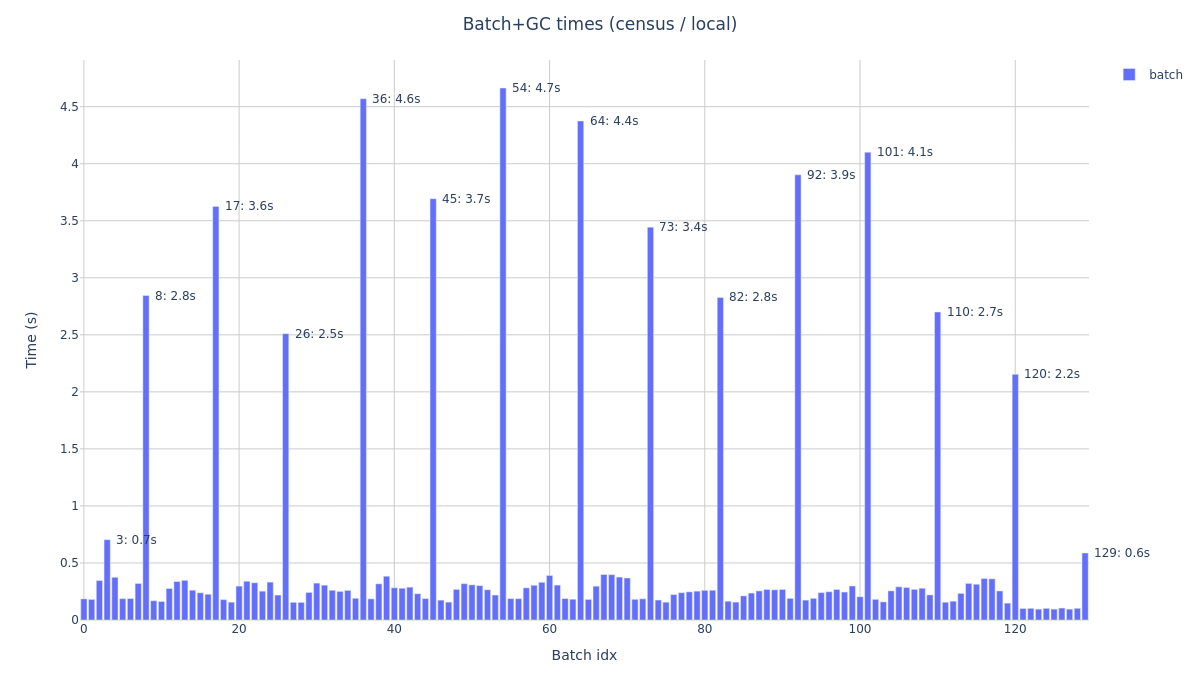

In [18]:
fig = px.bar(
    df.set_index('idx')[['batch', *(['gc'] if 'gc' in df else [])]],
    barmode='stack',
    labels={
        'idx': 'Batch idx',
        'variable': '',
        'value': 'Time (s)',
    },
    log_y=log_plot,
).update_layout(
    title=dict(text=f'Batch+GC times ({method} / {census_loc})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
)

if not ann.empty:
    anns = ann.set_index('idx').batch.to_dict().items()
    for idx, batch in anns:
        fig.add_annotation(
            x=idx, y=log10(batch) if log_plot else batch,
            showarrow=False,
            text=f'{idx}: {batch:.1f}s',
            xshift=7,
            xanchor='left',
        )

plot(fig, f'census-{census_loc}', fmt='png', save=['png'], w=width, h=height, dir='img',)